# MNIST

In [ ]:
## Uncomment to install dependencies if you aren't using `git clone && uv sync`
#!pip install datasets einops matplotlib numpy tqdm setuptools

In [2]:
from typing import *
import torch
from torch import nn
import datasets
from einops import rearrange
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

import hamux_torch as hmx

torch.manual_seed(42);

/nvmescratch/hoo/Projects/hamux-torch/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if not torch.cuda.is_available():
     print("⚠️  CUDA recommended for better performance")


In [4]:
def get_mnist_train_test():
    # Save to `data/`
    data_path = Path("data/")
    data_path.mkdir(parents=True, exist_ok=True)
    Xtrain_path, Xtest_path = data_path / "Xtrain_mnist.npy", data_path / "Xtest_mnist.npy"
    if not Xtrain_path.exists() or not Xtest_path.exists():
        print("Downloading MNIST data...")
        mnist = datasets.load_dataset("mnist").with_format("numpy")
        train_set = mnist['train']
        test_set = mnist['test']

        print("Saving Xtrain...")
        Xtrain = next(train_set.iter(len(train_set)))['image']
        np.save(Xtrain_path, Xtrain)
        print("Saving Xtest...")
        Xtest = next(test_set.iter(len(test_set)))['image']
        np.save(Xtest_path, Xtest)
        print("Done")
    
    Xtrain, Xtest = np.load(Xtrain_path), np.load(Xtest_path)
    return torch.from_numpy(Xtrain).float(), torch.from_numpy(Xtest).float()

In [5]:
Xtrain, Xtest = get_mnist_train_test()

def transform(x):
    x = x / 255.
    x = rearrange(x, "... h w -> ... (h w)") 
    x = x / ((x ** 2).sum(-1, keepdims=True)).sqrt()
    return x

Xtrain, Xtest = get_mnist_train_test()
Xtest = transform(Xtest)
Xtrain = transform(Xtrain)

In [6]:
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
cnorm=MidpointNormalize(midpoint=0.)

def show_img(img):
    img = img.detach().cpu().numpy()
    vmin, vmax = img.min(), img.max()
    vscale = max(np.abs(vmin), np.abs(vmax))
    cnorm = MidpointNormalize(midpoint=0., vmin=-vscale, vmax=vscale)
    
    fig, ax = plt.subplots(1,1)
    pcm = ax.imshow(img, cmap="seismic", norm=cnorm)
    ax.axis("off")
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
    fig.colorbar(pcm, cax=cbar_ax);
    return fig

In [7]:
class DenseSynapseHid(nn.Module):
    """This synapse captures the 'Dense Associative Memory' energy"""
    def __init__(self, x1_dim: int, x2_dim: int):
        super().__init__()
        self.W = nn.Parameter(torch.randn(x1_dim, x2_dim) * 0.02)
        self.beta = 1.

    @property
    def nW(self):
        "Normalize the weights"
        nc = torch.sqrt(torch.sum(self.W ** 2, dim=0, keepdim=True))
        return self.W / nc
        
    def __call__(self, xhat1):
        """Compute the energy of the synapse"""
        x2 = xhat1 @ self.nW
        return - 1/self.beta * torch.logsumexp(self.beta * x2, dim=-1)

In [11]:

neurons = {
    "input": hmx.NeuronLayer(hmx.lagr_spherical_norm, (784,)),
}
synapses = {
    "s1": DenseSynapseHid(784, 900),
}
connections = [
    (["input"], "s1")
]

ham = hmx.HAM(neurons, synapses, connections).vectorize()
xs = ham.init_states(bs=1)
xhats = ham.activations(xs)

# PyTorch optimizer
opt = torch.optim.Adam(ham.parameters(), lr=4e-2)

In [12]:
n_epochs = 20
batch_size = 100
nsteps = 1  # Energy descent steps
alpha = 1.0  # Energy descent step size

# Set random seeds for reproducibility
torch.manual_seed(100)

@torch.compile
def energy_descent_step(ham, xs, alpha):
    xhats = ham.activations(xs)
    egrad, evalue = ham.dEdact(xhats, xs, return_energy=True)
    for key in xs:
        xs[key] = xs[key] - alpha * egrad[key]
    return xs

# Training loop
for epoch in tqdm(range(n_epochs), desc="Training"):
    # Shuffle data
    perm = torch.randperm(Xtrain.size(0))
    
    epoch_loss = 0.0
    num_batches = 0
    
    for i in range(0, Xtrain.size(0), batch_size):
        # Get batch
        batch_idx = perm[i:i + batch_size]
        img_batch = Xtrain[batch_idx]
        
        # Zero gradients
        opt.zero_grad()
        
        # Initialize states
        xs = ham.init_states(bs=img_batch.shape[0])
        xs["input"] = img_batch.clone()
        
        # Add noise to input
        noise = torch.randn_like(img_batch) * 0.3
        xs['input'] = xs['input'] + noise
        
        # Energy descent dynamics (nsteps iterations)
        for _ in range(nsteps):
            xs = energy_descent_step(ham, xs, alpha)
            # xhats = ham.activations(xs)
            # egrad, evalue = ham.dEdact(xhats, xs, return_energy=True)
            # # Update states by descending energy
            # for key in xs:
            #     xs[key] = xs[key] - alpha * egrad[key]
        
        # Final reconstruction
        xhats = ham.activations(xs)
        img_final = xhats['input']
        
        # Compute loss (MSE between final and original)
        loss = ((img_final - img_batch) ** 2).mean()
        
        # Backprop and optimize
        loss.backward()
        opt.step()
        
        # Track metrics
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}")

Training:   5%|▌         | 1/20 [00:05<01:39,  5.26s/it]

Epoch 1/20, Loss: 0.000964


Training:  10%|█         | 2/20 [00:09<01:28,  4.90s/it]

Epoch 2/20, Loss: 0.000937


Training:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/it]

Epoch 3/20, Loss: 0.000937


Training:  20%|██        | 4/20 [00:19<01:16,  4.78s/it]

Epoch 4/20, Loss: 0.000937


Training:  25%|██▌       | 5/20 [00:24<01:11,  4.75s/it]

Epoch 5/20, Loss: 0.000936


Training:  30%|███       | 6/20 [00:28<01:05,  4.70s/it]

Epoch 6/20, Loss: 0.000932


Training:  35%|███▌      | 7/20 [00:33<01:00,  4.68s/it]

Epoch 7/20, Loss: 0.000915


Training:  40%|████      | 8/20 [00:37<00:56,  4.67s/it]

Epoch 8/20, Loss: 0.000881


Training:  45%|████▌     | 9/20 [00:42<00:51,  4.69s/it]

Epoch 9/20, Loss: 0.000858


Training:  50%|█████     | 10/20 [00:47<00:46,  4.70s/it]

Epoch 10/20, Loss: 0.000844


Training:  55%|█████▌    | 11/20 [00:52<00:42,  4.73s/it]

Epoch 11/20, Loss: 0.000833


Training:  60%|██████    | 12/20 [00:57<00:38,  4.76s/it]

Epoch 12/20, Loss: 0.000825


Training:  65%|██████▌   | 13/20 [01:01<00:33,  4.79s/it]

Epoch 13/20, Loss: 0.000820


Training:  70%|███████   | 14/20 [01:06<00:28,  4.80s/it]

Epoch 14/20, Loss: 0.000817


Training:  75%|███████▌  | 15/20 [01:11<00:24,  4.81s/it]

Epoch 15/20, Loss: 0.000813


Training:  80%|████████  | 16/20 [01:16<00:19,  4.82s/it]

Epoch 16/20, Loss: 0.000810


Training:  85%|████████▌ | 17/20 [01:21<00:14,  4.83s/it]

Epoch 17/20, Loss: 0.000808


Training:  90%|█████████ | 18/20 [01:26<00:09,  4.82s/it]

Epoch 18/20, Loss: 0.000806


Training:  95%|█████████▌| 19/20 [01:30<00:04,  4.83s/it]

Epoch 19/20, Loss: 0.000805


Training: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]

Epoch 20/20, Loss: 0.000803


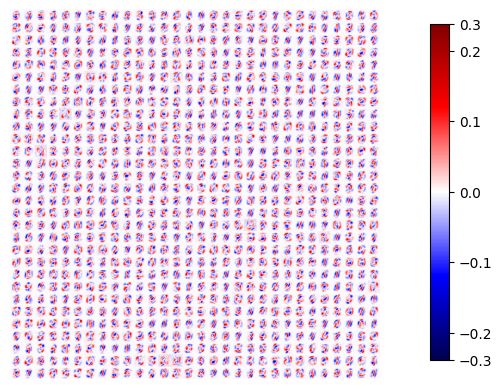

In [13]:
myW = ham.hypersynapses["s1"].nW
kh = kw = int(np.sqrt(myW.shape[-1]))
show_img(rearrange(myW, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw));